# Trading Strategies powered by Machine Learning - Random Forest Classifier

## Random Forest Classifier with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
from backtesting import Strategy
from sklearn.ensemble import RandomForestClassifier

## Getting the Data

In [4]:
XAUUSD = load_data()

In [5]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [6]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


## ML

### Class and Strategy ML

In [7]:
class Random_Forest_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [8]:
strategy = Random_Forest_Classifier
account_size = 1000
folder_ML_Strategy = 'Random Forest Classifier'

In [9]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
from util.ATR import *
from util.SMA import *
from util.RSI import *
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_RFC():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def get_rsi(self, df, rsi_period):
        chg = df['Close'].diff(1)
        gain = chg.mask(chg < 0, 0)
        loss = chg.mask(chg > 0, 0)
        avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        rs = abs(avg_gain/avg_loss)
        rsi = 100 - (100/(1+rs))
        return rsi

    def Create_Features(self):

        df = self.data.copy()

        # relative strength index
        df['rsi14'] = self.get_rsi(df, 14)
        df['ATR'] = ATR(df, 20)['ATR']

        periods = 14
        moving_av = 3

        df["roll_low"] = df['Low'].rolling(periods).min()
        df["roll_high"] = df['High'].rolling(periods).max()
        df["K"] = (df.Close - df.roll_low) / (df.roll_high - df.roll_low) * 100
        df["D"] = df.K.rolling(moving_av).mean()

        df = df.drop('roll_low', axis=1)
        df = df.drop('roll_high', axis=1)

        self.data = df

    def Add_Signal(self):

        df = self.data.copy()
        df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))
        df['signal_t1'] = np.sign(df.returns)
        df['signal'] = df.signal_t1.shift(-1)
        df = df.drop(columns=['returns', 'signal_t1'])
        df = df.dropna()

        self.data = df

    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        y_train = self.data_train['signal'].copy()
        x_train = self.data_train.drop(columns=['signal'])
        x_test = self.data_test.drop(columns=['signal'])

        self.model = RandomForestClassifier()
        self.model.fit(x_train, y_train)

        # Make predictions
        self.data_train['pred'] = self.model.predict(x_train)
        self.data_test['pred'] = self.model.predict(x_test)

    def Backtest(self, data, account_size=1000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [10]:
ML_Class = ML_RFC

## TF D1

In [11]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [12]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [13]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [14]:
train

Start                     2007-01-24 00:00:00
End                       2019-12-31 00:00:00
Duration                   4724 days 00:00:00
Exposure Time [%]                   99.950397
Equity Final [$]                    32852.746
Equity Peak [$]                     32852.753
Return [%]                          3185.2746
Buy & Hold Return [%]              134.605201
Return (Ann.) [%]                   24.390075
Volatility (Ann.) [%]                3.129627
Sharpe Ratio                         7.793286
Sortino Ratio                      285.941751
Calmar Ratio                       103.088371
Max. Drawdown [%]                   -0.236594
Avg. Drawdown [%]                   -0.016268
Max. Drawdown Duration        5 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                 2077
Win Rate [%]                        97.929706
Best Trade [%]                      15.845498
Worst Trade [%]                      -0.77578
Avg. Trade [%]                    

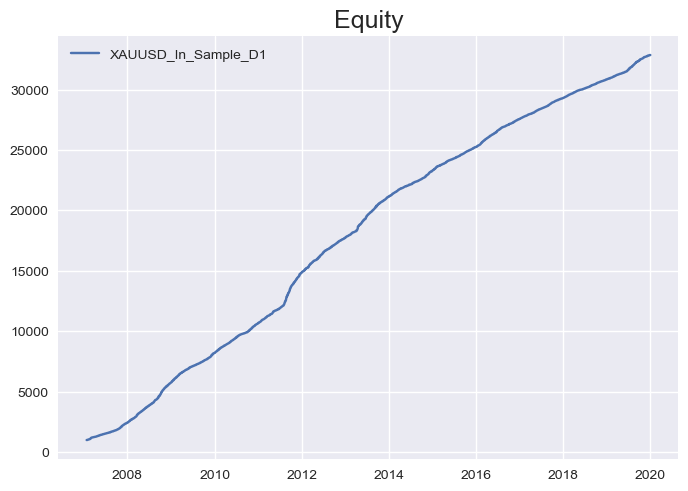

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                     1100.005
Equity Peak [$]                      1247.579
Return [%]                            10.0005
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                    2.455865
Volatility (Ann.) [%]               33.342118
Sharpe Ratio                         0.073657
Sortino Ratio                        0.120611
Calmar Ratio                         0.050654
Max. Drawdown [%]                  -48.483119
Avg. Drawdown [%]                   -6.518839
Max. Drawdown Duration      598 days 00:00:00
Avg. Drawdown Duration       55 days 00:00:00
# Trades                                  234
Win Rate [%]                        57.692308
Best Trade [%]                        5.01552
Worst Trade [%]                     -11.89115
Avg. Trade [%]                    

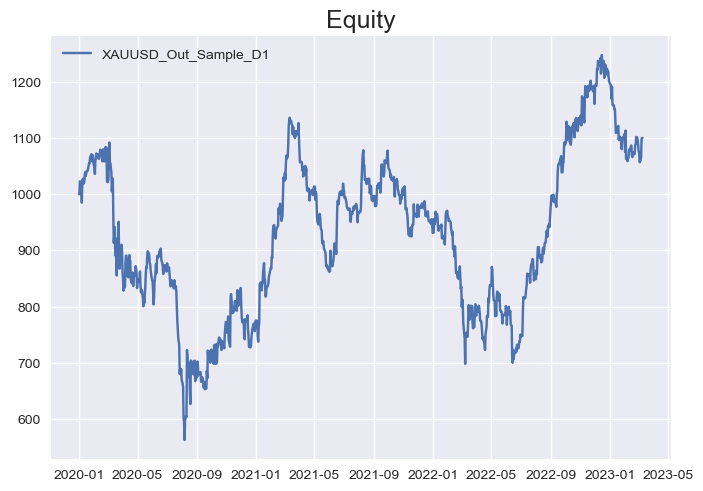

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [18]:
filename_train = f'result_{TF}_In_Sample.csv'

In [19]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [20]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [21]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [22]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [23]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [24]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [25]:
train

Start                     2007-01-04 08:00:00
End                       2019-12-31 20:00:00
Duration                   4744 days 12:00:00
Exposure Time [%]                   99.990408
Equity Final [$]                    68342.525
Equity Peak [$]                     68345.311
Return [%]                          6734.2525
Buy & Hold Return [%]              141.990881
Return (Ann.) [%]                   30.002538
Volatility (Ann.) [%]                3.713509
Sharpe Ratio                         8.079296
Sortino Ratio                      619.380076
Calmar Ratio                       217.444823
Max. Drawdown [%]                   -0.137978
Avg. Drawdown [%]                   -0.008276
Max. Drawdown Duration        4 days 04:00:00
Avg. Drawdown Duration        1 days 06:00:00
# Trades                                10739
Win Rate [%]                        98.314554
Best Trade [%]                      11.391034
Worst Trade [%]                     -0.761831
Avg. Trade [%]                    

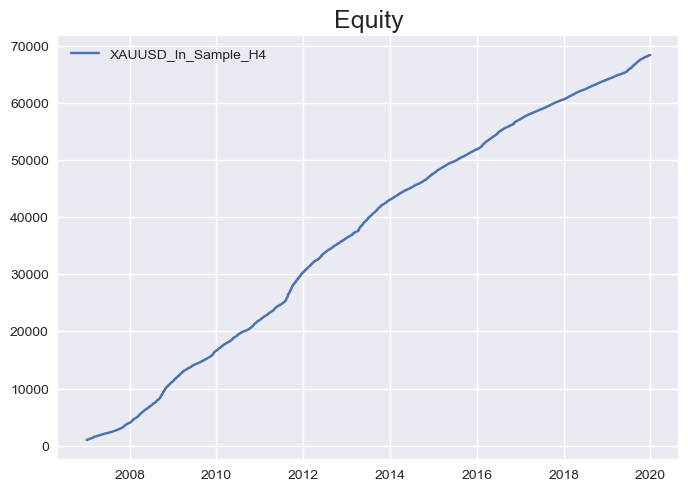

In [26]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [27]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                     1287.836
Equity Peak [$]                       1372.23
Return [%]                            28.7836
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                    6.643966
Volatility (Ann.) [%]               32.940888
Sharpe Ratio                         0.201694
Sortino Ratio                        0.308904
Calmar Ratio                         0.132577
Max. Drawdown [%]                  -50.114023
Avg. Drawdown [%]                   -4.256055
Max. Drawdown Duration      621 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                 1743
Win Rate [%]                        48.881239
Best Trade [%]                       4.324288
Worst Trade [%]                     -6.177515
Avg. Trade [%]                    

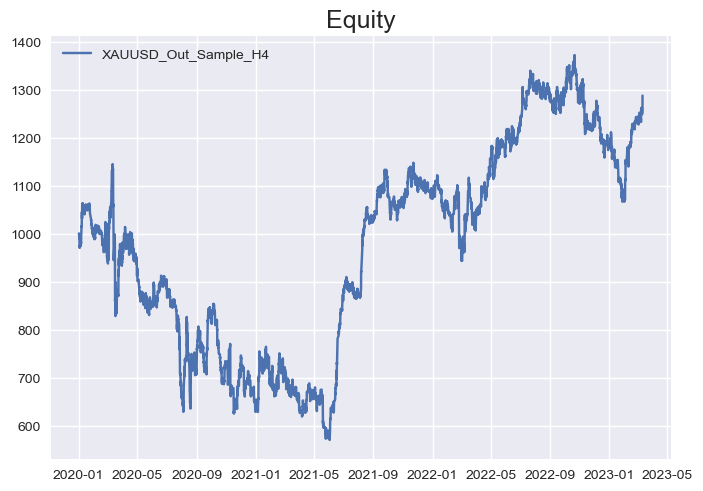

In [28]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [29]:
filename_train = f'result_{TF}_In_Sample.csv'

In [30]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [31]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [32]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [33]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [34]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [35]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [36]:
train

Start                     2007-01-01 20:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 01:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                   129585.239
Equity Peak [$]                    129586.022
Return [%]                         12858.5239
Buy & Hold Return [%]              138.603939
Return (Ann.) [%]                   35.331427
Volatility (Ann.) [%]                5.075228
Sharpe Ratio                         6.961546
Sortino Ratio                     1086.554852
Calmar Ratio                       198.967595
Max. Drawdown [%]                   -0.177574
Avg. Drawdown [%]                   -0.005087
Max. Drawdown Duration        3 days 14:00:00
Avg. Drawdown Duration        0 days 09:00:00
# Trades                                41571
Win Rate [%]                        97.457362
Best Trade [%]                      10.936788
Worst Trade [%]                     -0.930384
Avg. Trade [%]                    

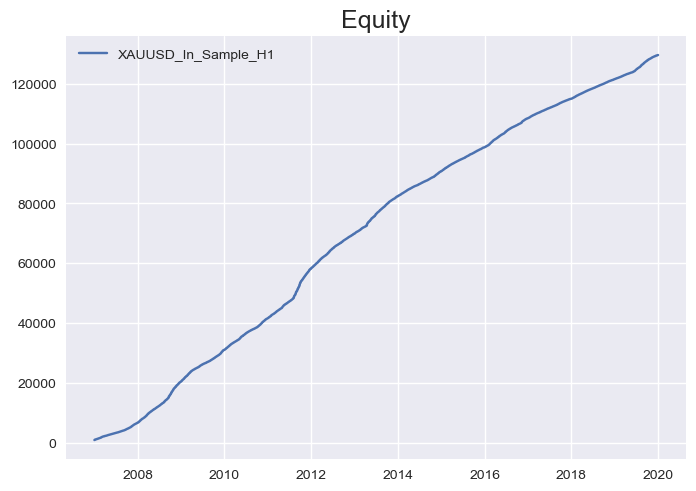

In [37]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [38]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                      797.972
Equity Peak [$]                      1130.919
Return [%]                           -20.2028
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                   -5.577265
Volatility (Ann.) [%]               35.849699
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -61.526776
Avg. Drawdown [%]                   -3.151266
Max. Drawdown Duration     1089 days 03:00:00
Avg. Drawdown Duration       36 days 08:00:00
# Trades                                 6827
Win Rate [%]                         53.05405
Best Trade [%]                        5.43235
Worst Trade [%]                     -2.953729
Avg. Trade [%]                    

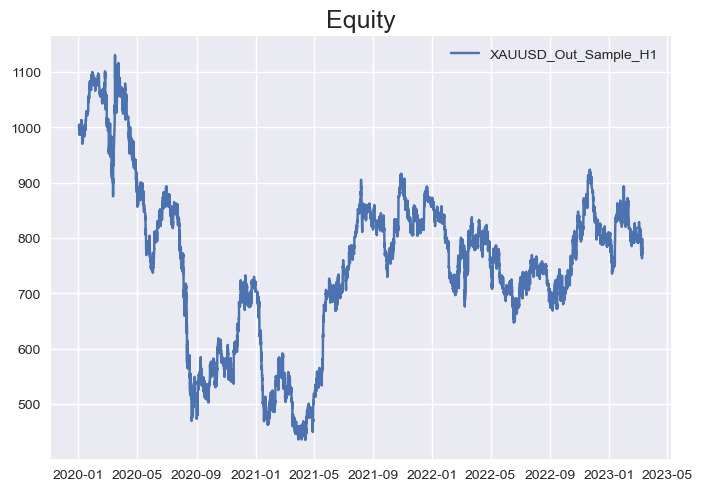

In [39]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [40]:
filename_train = f'result_{TF}_In_Sample.csv'

In [41]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [42]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [43]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [44]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [45]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [46]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [47]:
train

Start                     2007-01-01 10:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 11:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                   181401.752
Equity Peak [$]                    181402.472
Return [%]                         18040.1752
Buy & Hold Return [%]              138.590804
Return (Ann.) [%]                   38.180317
Volatility (Ann.) [%]                5.996981
Sharpe Ratio                         6.366589
Sortino Ratio                     4661.999366
Calmar Ratio                       194.831347
Max. Drawdown [%]                   -0.195966
Avg. Drawdown [%]                   -0.004766
Max. Drawdown Duration        3 days 09:30:00
Avg. Drawdown Duration        0 days 04:31:00
# Trades                                82664
Win Rate [%]                        97.281767
Best Trade [%]                       8.111091
Worst Trade [%]                     -0.961891
Avg. Trade [%]                    

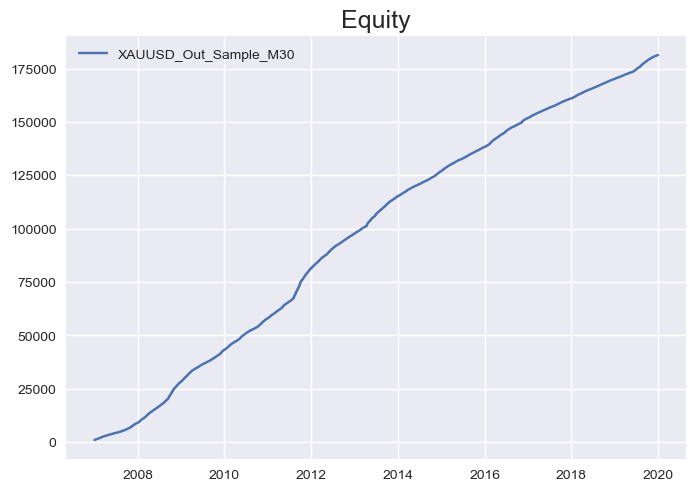

In [48]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [49]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                     1377.405
Equity Peak [$]                      1421.955
Return [%]                            37.7405
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                    8.483027
Volatility (Ann.) [%]               27.592927
Sharpe Ratio                         0.307435
Sortino Ratio                         0.48428
Calmar Ratio                         0.307835
Max. Drawdown [%]                  -27.557075
Avg. Drawdown [%]                   -1.590179
Max. Drawdown Duration      298 days 03:00:00
Avg. Drawdown Duration        9 days 12:04:00
# Trades                                14054
Win Rate [%]                        54.546748
Best Trade [%]                        1.97118
Worst Trade [%]                      -4.41879
Avg. Trade [%]                    

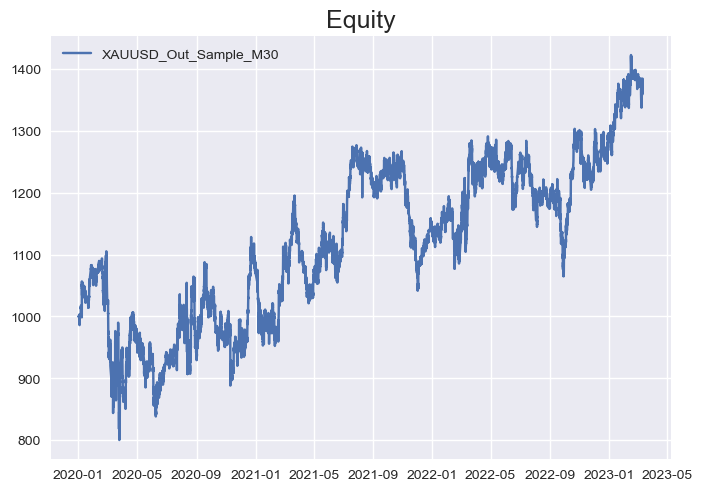

In [50]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [51]:
filename_train = f'result_{TF}_In_Sample.csv'

In [52]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [53]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [54]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [55]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [56]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [57]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [58]:
train

Start                     2014-09-23 18:00:00
End                       2019-12-31 21:45:00
Duration                   1925 days 03:45:00
Exposure Time [%]                   99.998394
Equity Final [$]                     82743.15
Equity Peak [$]                       82743.6
Return [%]                           8174.315
Buy & Hold Return [%]               24.022461
Return (Ann.) [%]                   96.833624
Volatility (Ann.) [%]               18.710601
Sharpe Ratio                         5.175335
Sortino Ratio                     3608.753645
Calmar Ratio                       194.410203
Max. Drawdown [%]                   -0.498089
Avg. Drawdown [%]                   -0.001796
Max. Drawdown Duration        3 days 06:15:00
Avg. Drawdown Duration        0 days 03:58:00
# Trades                                64792
Win Rate [%]                        98.635634
Best Trade [%]                       3.051941
Worst Trade [%]                     -1.220078
Avg. Trade [%]                    

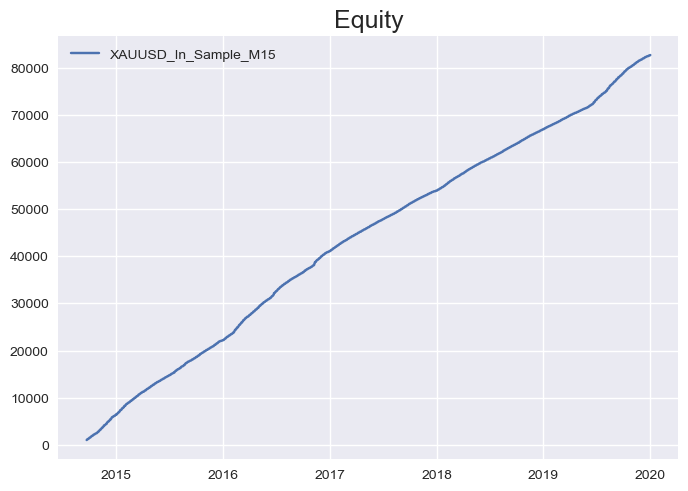

In [59]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [60]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.997348
Equity Final [$]                      2557.49
Equity Peak [$]                      2712.413
Return [%]                            155.749
Buy & Hold Return [%]               22.665911
Return (Ann.) [%]                   26.995678
Volatility (Ann.) [%]               23.291151
Sharpe Ratio                         1.159053
Sortino Ratio                         2.44152
Calmar Ratio                          1.15148
Max. Drawdown [%]                   -23.44434
Avg. Drawdown [%]                   -0.537463
Max. Drawdown Duration      228 days 09:00:00
Avg. Drawdown Duration        1 days 22:18:00
# Trades                                17113
Win Rate [%]                        59.744054
Best Trade [%]                       2.780288
Worst Trade [%]                     -3.961889
Avg. Trade [%]                    

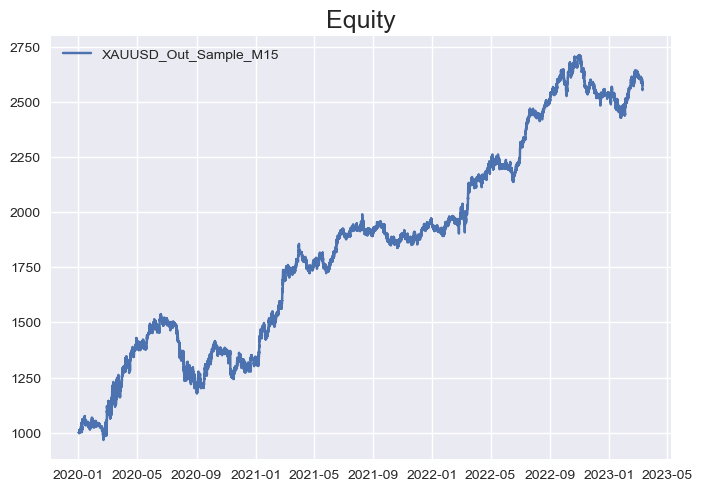

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [62]:
filename_train = f'result_{TF}_In_Sample.csv'

In [63]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [64]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [65]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [66]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [67]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [68]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [69]:
train

Start                     2020-05-15 12:50:00
End                       2022-12-30 21:55:00
Duration                    959 days 09:05:00
Exposure Time [%]                   99.998928
Equity Final [$]                   129964.363
Equity Peak [$]                    129964.948
Return [%]                         12896.4363
Buy & Hold Return [%]                4.609869
Return (Ann.) [%]                  337.512332
Volatility (Ann.) [%]               99.500307
Sharpe Ratio                         3.392073
Sortino Ratio                     4255.516193
Calmar Ratio                       852.188312
Max. Drawdown [%]                   -0.396054
Avg. Drawdown [%]                   -0.000854
Max. Drawdown Duration        3 days 04:30:00
Avg. Drawdown Duration        0 days 01:11:00
# Trades                                95756
Win Rate [%]                        98.775011
Best Trade [%]                       2.888443
Worst Trade [%]                     -0.876337
Avg. Trade [%]                    

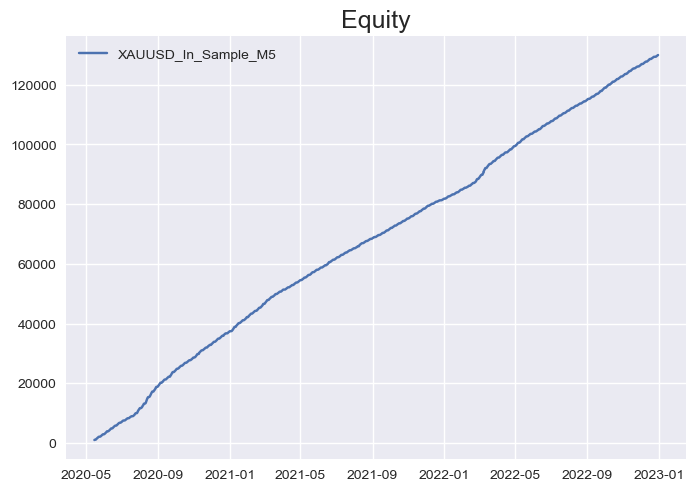

In [70]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [71]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:50:00
Duration                     66 days 18:50:00
Exposure Time [%]                   99.985069
Equity Final [$]                     1077.366
Equity Peak [$]                      1129.188
Return [%]                             7.7366
Buy & Hold Return [%]                 2.07534
Return (Ann.) [%]                   37.174262
Volatility (Ann.) [%]               30.264355
Sharpe Ratio                         1.228318
Sortino Ratio                        2.481055
Calmar Ratio                         2.697699
Max. Drawdown [%]                  -13.779991
Avg. Drawdown [%]                   -0.623055
Max. Drawdown Duration       35 days 04:20:00
Avg. Drawdown Duration        0 days 19:43:00
# Trades                                 5832
Win Rate [%]                        53.377915
Best Trade [%]                       0.994702
Worst Trade [%]                     -0.867229
Avg. Trade [%]                    

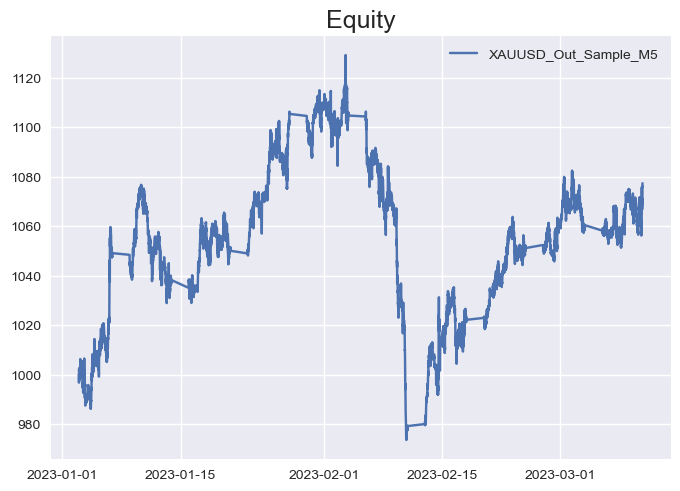

In [72]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [73]:
filename_train = f'result_{TF}_In_Sample.csv'

In [74]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [75]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [76]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [77]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [78]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [79]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\Win10\AppData\Local\Temp\ipykernel_13860\3716381769.py:97: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [80]:
train

Start                     2022-08-16 23:33:00
End                       2022-12-30 21:58:00
Duration                    135 days 22:25:00
Exposure Time [%]                   99.997745
Equity Final [$]                    37774.185
Equity Peak [$]                     37774.608
Return [%]                          3677.4185
Buy & Hold Return [%]                2.713066
Return (Ann.) [%]               248397.818922
Volatility (Ann.) [%]           207466.025478
Sharpe Ratio                         1.197294
Sortino Ratio                             inf
Calmar Ratio                   6527097.696362
Max. Drawdown [%]                   -0.038056
Avg. Drawdown [%]                    -0.00061
Max. Drawdown Duration        3 days 01:08:00
Avg. Drawdown Duration        0 days 00:11:00
# Trades                                65853
Win Rate [%]                        96.698708
Best Trade [%]                        1.29732
Worst Trade [%]                     -0.378417
Avg. Trade [%]                    

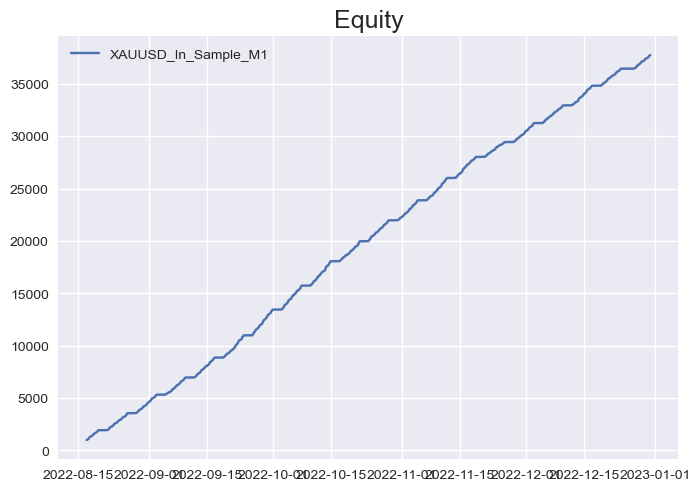

In [81]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [82]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:58:00
Duration                     66 days 18:58:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1002.949
Equity Peak [$]                       1052.42
Return [%]                             0.2949
Buy & Hold Return [%]                2.050654
Return (Ann.) [%]                    4.190383
Volatility (Ann.) [%]               30.579849
Sharpe Ratio                         0.137031
Sortino Ratio                        0.252937
Calmar Ratio                         0.270935
Max. Drawdown [%]                   -15.46637
Avg. Drawdown [%]                    -0.49344
Max. Drawdown Duration       42 days 15:14:00
Avg. Drawdown Duration        0 days 19:04:00
# Trades                                 5871
Win Rate [%]                        54.334866
Best Trade [%]                       1.162744
Worst Trade [%]                     -1.469021
Avg. Trade [%]                    

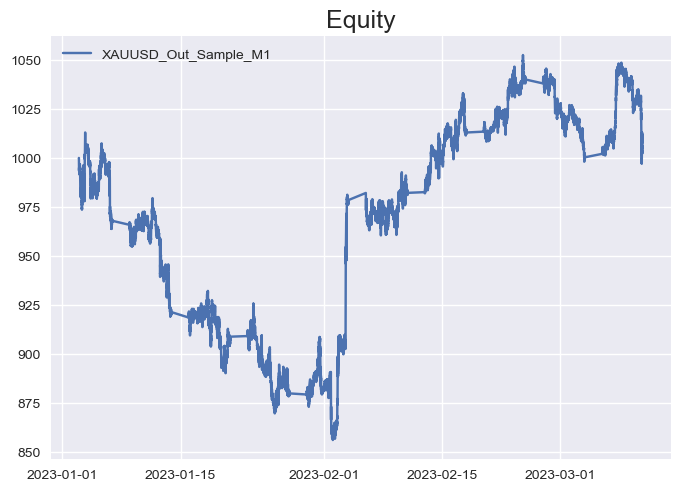

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [84]:
filename_train = f'result_{TF}_In_Sample.csv'

In [85]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')